# Main Plotting of liftetime exposure for water scarcity -- remake
For water scarcity
Main script for plotting, does analysis based on script

In [10]:
import os
import xarray as xr
import pickle as pk
import time
import matplotlib as mpl
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from settings import *
from load_manip import *
from exposure import * 
from utils import *
from main_function import *
from plotting import *

import warnings
warnings.filterwarnings("ignore")

# set own plotting parameters
set_plot_param()
map_proj = ccrs.Robinson(central_longitude=0, globe=None)


# customized plotting parameters

labelfontsize=14
titlesize=16
labelsize=titlesize
mpl.rc('xtick',labelsize=labelfontsize)
mpl.rc('ytick',labelsize=labelfontsize)
mpl.rc('axes',titlesize=titlesize)
mpl.rc('axes',labelsize=labelsize)
mpl.rc('legend',fontsize='large')

%matplotlib inline 

In [11]:
# extreme event
global flags

flags = {}

flags['mode'] = 'exposure'   # whether to calculate exposure, duration, intensity or all. 

flags['runs'] = 0           # 0: do not process ISIMIP runs (i.e. load runs pickle)
                            # 1: process ISIMIP runs (i.e. produce and save runs as pickle)
flags['mask'] = 0           # 0: do not process country data (i.e. load masks pickle)
                            # 1: process country data (i.e. produce and save masks as pickle)
flags['exposure'] = 0     # 0: do not process ISIMIP runs to compute exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute exposure (i.e. produce and save exposure as pickle)
flags['exposure_pic'] = 0   # 0: do not process ISIMIP runs to compute picontrol exposure (i.e. load exposure pickle)
                            # 1: process ISIMIP runs to compute picontrol exposure (i.e. produce and save exposure as pickle)
flags['expectancy'] = 0     # 1: apply option of constant life expectancy

rcps = ['RCP60','RCP26']
rcp_text = {'RCP60': 'RCP 6.0', 'RCP26' : 'RCP 2.6'  }

labels = ['a.','b.','c.','d.','e.','f.','g.','h.','f.']
labels = ['A','B','C','D','E','F','G','H','F']


regions =['East Asia & Pacific', 'Europe & Central Asia', 'Latin America & Caribbean', 'Middle East & North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa']
# TODO: add rest of flags

### Load and manipulate  files for plotting

In [12]:
# load country borders (from pickles)

d_countries = pd.read_pickle(open('./data/pickles/country_info.pkl', 'rb'))
df_countries = d_countries['info_pop']

# unpack country information
gdf_country_borders = d_countries['borders']

# load cohort info
d_regions = pd.read_pickle(open('./data/pickles/region_info.pkl', 'rb'))

# unpack region information
df_birthyears_regions = d_regions['birth_years']
df_life_expectancy_5_regions = d_regions['life_expectancy_5']
d_cohort_weights_regions = d_regions['cohort_size']
d_cohort_size = d_countries['cohort_size']
d_all_cohorts = d_countries['all_cohorts']

## Calculate or load water scarcity index

In [13]:
# load or calculate the lifetime water scarcity for the water scarcity or falkenmark index, for the RCP scenarios

def calc_lifetime_scarcityindices_RCPs(flags):

    ds_waterscarcity, ds_waterscarcity_perregion, d_waterscarcity_allruns = do_lifetime_analysis(flags)

    ## find indices of RCP scenarios per simulation

    # unpack info from isimip simulations - to know RCP scenario
    with open('./data/pickles/isimip_metadata_{}_{}.pkl'.format(flags['extr'],'exposure'), 'rb') as f:
        d_isimip_meta = pd.read_pickle(f)

    ind_rcp26 = []
    ind_rcp60 = []
    for i in d_isimip_meta.keys(): 
        if d_isimip_meta[i]['rcp'] == 'rcp26':
            ind_rcp26.append(i)
        elif d_isimip_meta[i]['rcp'] == 'rcp60':
            ind_rcp60.append(i)

    # filter simulations based on RCP scenario
    d_waterscarcity_rcp26runs = {i: d_waterscarcity_allruns['exposure_perrun_RCP'][i] for i in ind_rcp26}
    d_waterscarcity_rcp60runs = {i: d_waterscarcity_allruns['exposure_perrun_RCP'][i] for i in ind_rcp60}


    # average of both RCPs

    ds_waterscarcity_RCP26 = calc_exposure_mmm_xr(d_waterscarcity_rcp26runs, 'country', 'RCP26' )
    ds_waterscarcity_RCP60 = calc_exposure_mmm_xr(d_waterscarcity_rcp60runs, 'country', 'RCP60' )

    # pool all datasets for different trajectories
    ds_waterscarcity = xr.merge([  ds_waterscarcity_RCP26,  ds_waterscarcity_RCP60])

    # per region (calculating based on country withdrawal and deficit vs averaging country % water deficits directly)
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)

    # calculate pct water deficit per region (weighted average based on cohort size) based on waterdeficit/withdrawal *100 for every country
    # (This is alternative to what is done in the main function: calculating the waterdeficit and withdrawal per region based on countries and only then taking the ratio)
    d_waterscarcity_perregion_perrun_RCP26 = calc_pctwaterdeficit_perregion_perrun(d_waterscarcity_rcp26runs)
    d_waterscarcity_perregion_perrun_RCP60 = calc_pctwaterdeficit_perregion_perrun(d_waterscarcity_rcp60runs)

    # calculate multi-model statistics
    ds_waterscarcity_perregion_RCP26 = calc_exposure_mmm_xr(d_waterscarcity_perregion_perrun_RCP26, 'region', 'RCP26' )
    ds_waterscarcity_perregion_RCP60 = calc_exposure_mmm_xr(d_waterscarcity_perregion_perrun_RCP60, 'region', 'RCP60' )

    ds_waterscarcity_perregion = xr.merge([ ds_waterscarcity_perregion_RCP26,  ds_waterscarcity_perregion_RCP60])
    
    return ds_waterscarcity, ds_waterscarcity_perregion, d_waterscarcity_rcp26runs, d_waterscarcity_rcp60runs


In [14]:
# Calculate water scarcity index
flags['extr'] = 'waterscarcity'  
ds_waterscarcity, ds_waterscarcity_perregion, d_waterscarcity_rcp26runs, d_waterscarcity_rcp60runs = calc_lifetime_scarcityindices_RCPs(flags)


Loading processed country and region data
Loading processed isimip data
Loading processed exposures


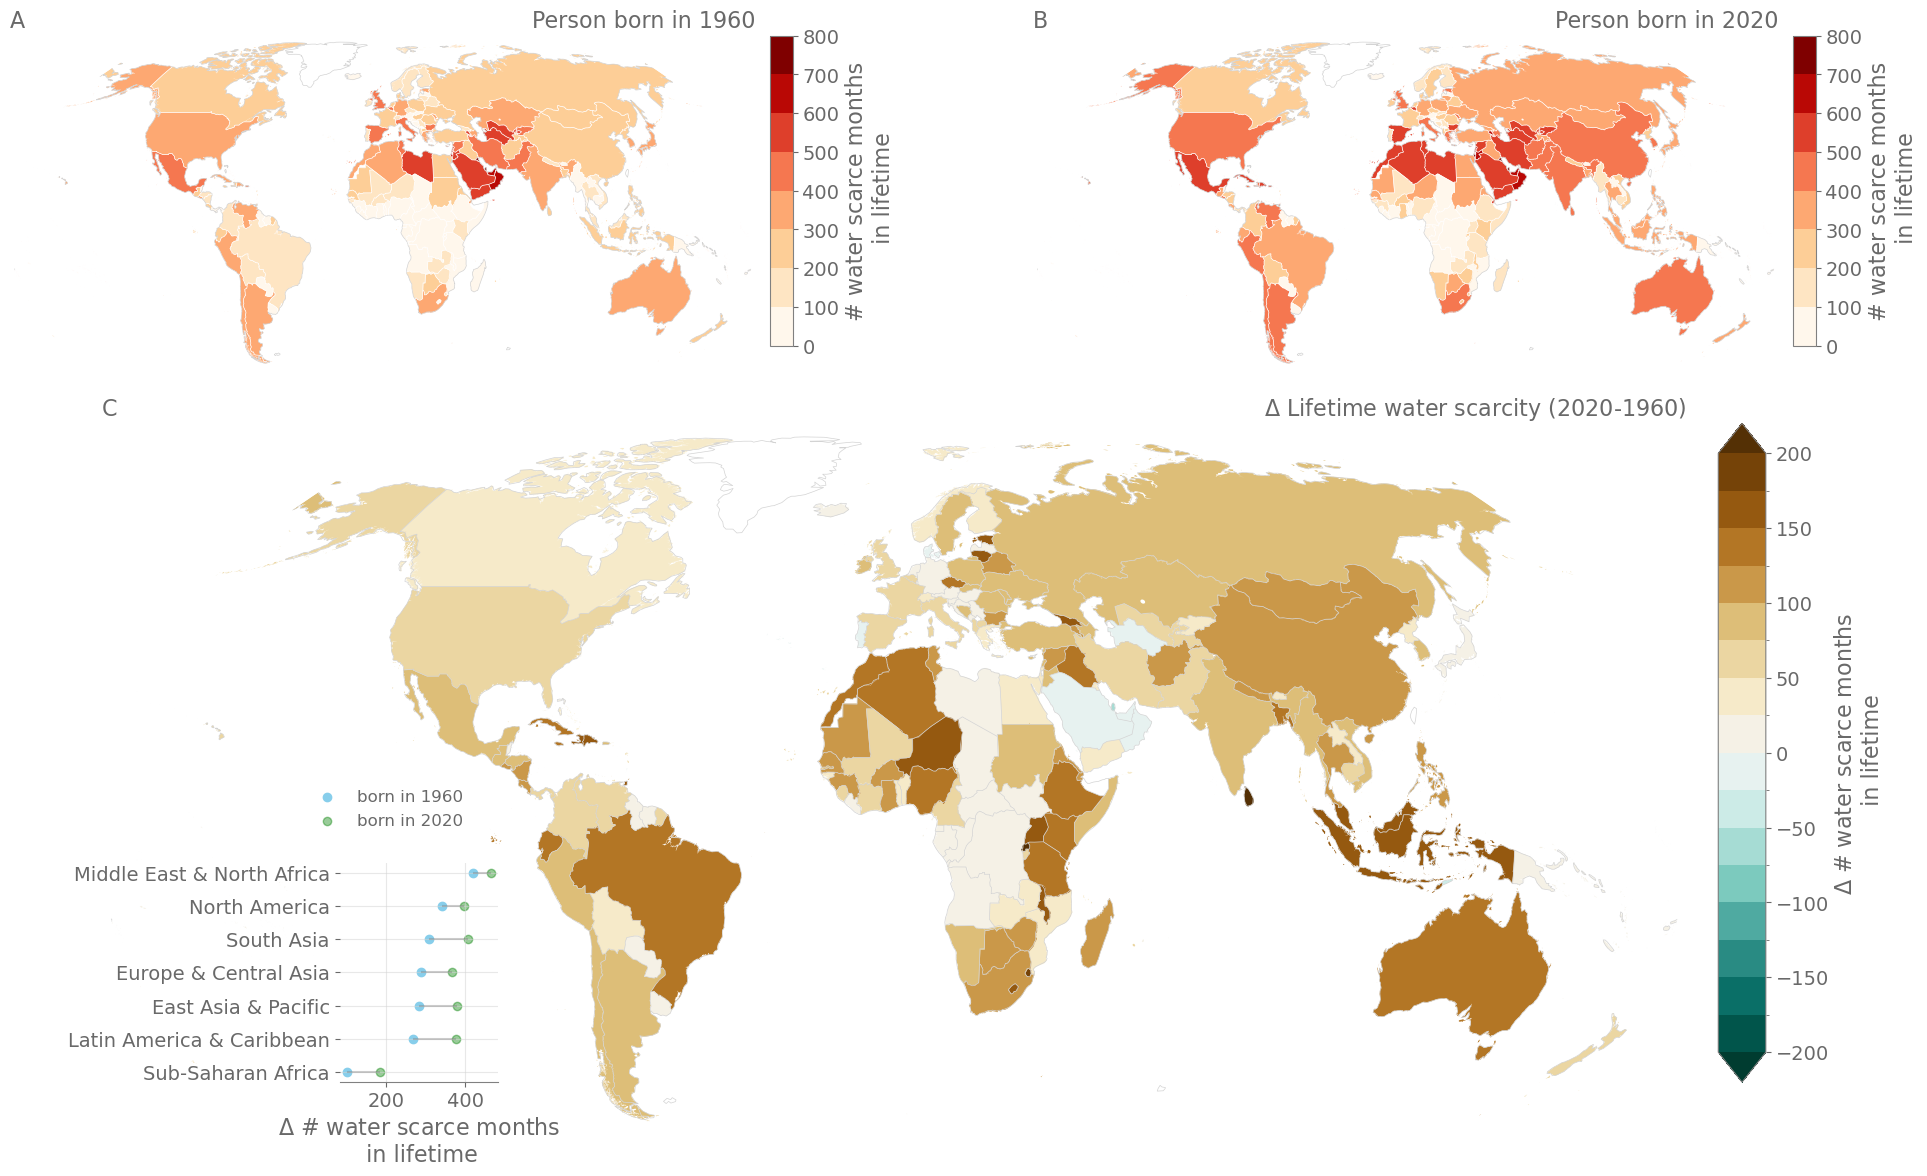

In [15]:
# ------------------------------------------------
# Create figure and load variable

fig = plt.figure(figsize=(30,12))

rcp = 'RCP60'
variable = 'mmm_'+rcp
da = ds_waterscarcity[variable]


# colorbar settings for 2 upper plots
bounds = np.array([0,100,200,300,400,500,600,700,800])
legend_label = "# water scarce months\n in lifetime"


# ------------------------------------------------
# Panel a 
ax = plt.subplot2grid(shape=(3,3), loc=(0,0), colspan=1, projection=map_proj)

# ax settings
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

# data plotting
birth_year = 1960
df_1960 = da.sel({'birth_year' : birth_year}).to_dataframe()
gdf_exposure_birthyear = gdf_country_borders.merge(df_1960[variable], left_index=True, right_on='country')
gdf_exposure_birthyear.plot(ax=ax, column=variable, cax=cax, legend = True,  cmap='OrRd', legend_kwds={'label': legend_label}, vmax=800, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))

# title settings
ax.set_title('Person born in '+str(birth_year), loc='right'); 
ax.set_title(labels[0], loc='left'); 


# ------------------------------------------------
# Panel b 
ax = plt.subplot2grid(shape=(3,3), loc=(0,1), colspan=1, projection=map_proj)

# ax settings
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

# data plotting
birth_year = 2020
df_2020 = da.sel({'birth_year' : birth_year}).to_dataframe()
gdf_exposure_birthyear = gdf_country_borders.merge(df_2020[variable], left_index=True, right_on='country')
gdf_exposure_birthyear.plot(ax=ax, column=variable, cax=cax, legend = True,  cmap='OrRd', legend_kwds={'label': legend_label}, vmax=800, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))

# title settings
ax.set_title('Person born in '+str(birth_year), loc='right'); 
ax.set_title(labels[1], loc='left'); 


# ------------------------------------------------
# Panel c 
ax = plt.subplot2grid(shape=(3,3), loc=(1,0), colspan=2, rowspan=2, projection=map_proj)


# colorbar settings
legend_label = '$\Delta$ '+ legend_label
bounds = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])
bounds = np.arange(-200,225,25)

# ax settings
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

# data plotting
d_waterdeficit = (df_2020-df_1960)
gdf_delta_birthyear = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
gdf_delta_birthyear.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label}, vmin=-300, vmax=300, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))

# title settings
ax.set_title('Person born in '+str(birth_year), loc='right'); 

ax.set_title('$\Delta$ Lifetime water scarcity (2020-1960)',  loc='right');
ax.set_title(labels[2], loc='left'); 


# ------------------------------------------------
# Panel d - inset lollipop plot

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

var_type = ''#'delta_'
rcp = 'RCP60'
var = 'mmm_'+var_type+rcp

# get values
df_temp = ds_waterscarcity_perregion[var].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_waterscarcity_perregion[var].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

df = df_1960[df_1960["regions"].isin(regions)].sort_values(by='1960',ascending=True) 

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)    
ax_inset.set_xlabel(legend_label)
ax_inset.grid(color='lightgray', alpha=0.5)
#ax_inset.set_xlim((15,85));
#ax_inset.set_title(labels[3], loc='left'); 

# ------------------------------------------------
# Save figure

fig.tight_layout()
plt.savefig('figures/si_waterscarcityindex.png', bbox_inches='tight',dpi=100)



### values

In [16]:
df_1960["diff_2020_1960"] = df_1960["2020"] - df_1960["1960"]
df_1960[["diff_2020_1960","regions"]]

,diff_2020_1960,regions
0,95.819753,East Asia & Pacific
1,78.073607,Europe & Central Asia
2,62.603927,High income
3,111.076055,Latin America & Caribbean
4,72.71518,Low income
5,72.227534,Lower middle income
6,45.633476,Middle East & North Africa
7,53.805047,North America
8,98.527583,South Asia
9,83.507728,Sub-Saharan Africa


## Falkenmark

In [17]:
# Calculate water scarcity index
flags['extr'] = 'falkenmark'  
ds_waterscarcity, ds_waterscarcity_perregion, d_waterscarcity_rcp26runs, d_waterscarcity_rcp60runs = calc_lifetime_scarcityindices_RCPs(flags)


Loading processed country and region data
Loading processed isimip data
Loading processed exposures


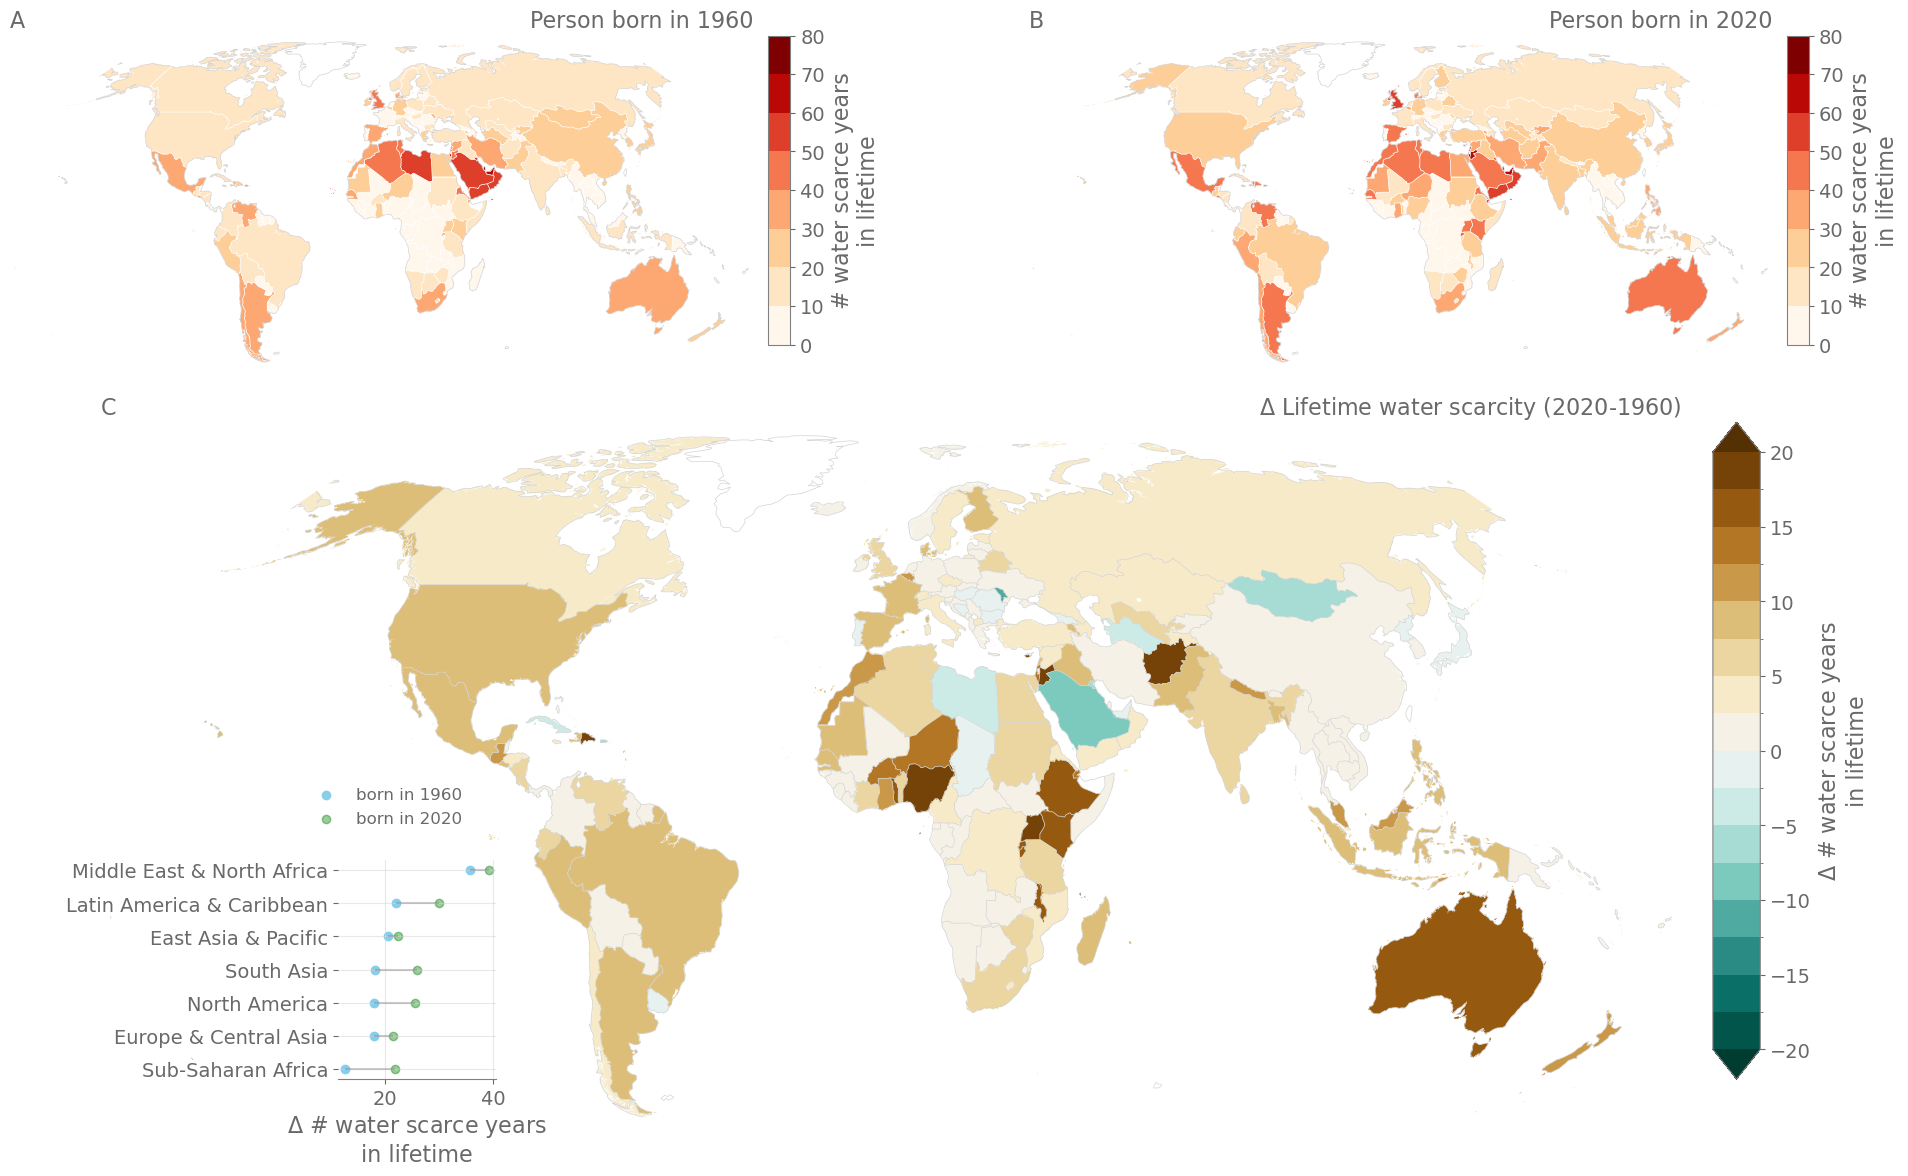

In [18]:
# ------------------------------------------------
# Create figure and load variable

fig = plt.figure(figsize=(30,12))

rcp = 'RCP60'
variable = 'mmm_'+rcp
da = ds_waterscarcity[variable]


# colorbar settings for 2 upper plots
bounds = np.array([0,10,20,30,40,50,60,70,80])
legend_label = "# water scarce years\nin lifetime"


# ------------------------------------------------
# Panel a 
ax = plt.subplot2grid(shape=(3,3), loc=(0,0), colspan=1, projection=map_proj)

# ax settings
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

# data plotting
birth_year = 1960
df_1960 = da.sel({'birth_year' : birth_year}).to_dataframe()
gdf_exposure_birthyear = gdf_country_borders.merge(df_1960[variable], left_index=True, right_on='country')
gdf_exposure_birthyear.plot(ax=ax, column=variable, cax=cax, legend = True,  cmap='OrRd', legend_kwds={'label': legend_label}, vmax=30, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))

# title settings
ax.set_title('Person born in '+str(birth_year), loc='right'); 
ax.set_title(labels[0], loc='left'); 


# ------------------------------------------------
# Panel b 
ax = plt.subplot2grid(shape=(3,3), loc=(0,1), colspan=1, projection=map_proj)

# ax settings
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

# data plotting
birth_year = 2020
df_2020 = da.sel({'birth_year' : birth_year}).to_dataframe()
gdf_exposure_birthyear = gdf_country_borders.merge(df_2020[variable], left_index=True, right_on='country')
gdf_exposure_birthyear.plot(ax=ax, column=variable, cax=cax, legend = True,  cmap='OrRd', legend_kwds={'label': legend_label}, vmax=30, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))

# title settings
ax.set_title('Person born in '+str(birth_year), loc='right'); 
ax.set_title(labels[1], loc='left'); 


# ------------------------------------------------
# Panel c 
ax = plt.subplot2grid(shape=(3,3), loc=(1,0), colspan=2, rowspan=2, projection=map_proj)


# colorbar settings
legend_label = '$\Delta$ '+ legend_label
bounds = np.array([-20,-15,-10,-5,0,5,10,15,20])
bounds = np.arange(-20,22.5,2.5)

# ax settings
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

# data plotting
d_waterdeficit = (df_2020-df_1960)
gdf_delta_birthyear = gdf_country_borders.merge(d_waterdeficit, left_index=True, right_on='country')
gdf_delta_birthyear.plot(ax=ax, column=variable, legend = True,  cmap='BrBG_r',  cax=cax, legend_kwds={'label': legend_label}, transform=ccrs.PlateCarree(), norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'))

# title settings
ax.set_title('Person born in '+str(birth_year), loc='right'); 

ax.set_title('$\Delta$ Lifetime water scarcity (2020-1960)',  loc='right');
ax.set_title(labels[2], loc='left'); 


# ------------------------------------------------
# Panel d - inset lollipop plot

ax_inset = ax.inset_axes([0.15, 0.1, 0.1, 0.3]) #[x0, y0, width, height]

var_type = ''#'delta_'
rcp = 'RCP60'
var = 'mmm_'+var_type+rcp

# get values
df_temp = ds_waterscarcity_perregion[var].sel(birth_year=1960).to_dataframe().drop(['birth_year'],axis=1)
values_2020 = ds_waterscarcity_perregion[var].sel(birth_year=2020).values

values = np.stack((df_temp.index.values,np.squeeze(df_temp.values),values_2020))
df_1960 = pd.DataFrame(values.T, columns=['regions','1960','2020'])

df = df_1960[df_1960["regions"].isin(regions)].sort_values(by='1960',ascending=True) 

my_range=range(1,len(df.index)+1)

# do plotting 
ax_inset.hlines(y=my_range, xmin=df['1960'], xmax=df['2020'], color='grey', alpha=0.4)
ax_inset.scatter(df['1960'], my_range, color='skyblue', alpha=1, label='born in 1960')
ax_inset.scatter(df['2020'], my_range, color='green', alpha=0.4 , label='born in 2020')

# plot settings
ax_inset.legend(bbox_to_anchor=(0.3,1.4), loc='upper center', frameon=False);
ax_inset.set_yticks(my_range)
ax_inset.set_yticklabels(df['regions']); 
ax_inset.spines[['right', 'left', 'top']].set_visible(False)
ax_inset.set_xlabel(legend_label)
ax_inset.grid(color='lightgray', alpha=0.5)
#ax_inset.set_xlim((15,85));
#ax_inset.set_title(labels[3], loc='left'); 


# ------------------------------------------------
# Save figure

fig.tight_layout()
plt.savefig('figures/si_falkenmark.png', bbox_inches='tight',dpi=100)

